# Copyright 2018 The TensorFlow Authors.
The notebook is adapted from Google TensorFlow2 official tutorials.

# Example: Classify images of handwriting digits

Import TensorFlow into your program:

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.7.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

Use `tf.data` to batch and shuffle the dataset:

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    # print('Original input shape {}'.format(x.shape))
    x = self.conv1(x)
    # print('Shape after Conv1 {}'.format(x.shape))
    x = self.flatten(x)
    # print('Shape after flatten {}'.format(x.shape))
    x = self.d1(x)
    # print('Shape after Dense1 {}'.format(x.shape))
    x = self.d2(x)
    # print('Shape after Dense2 {}'.format(x.shape))
    return x

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training: 

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 1

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.04036923125386238, Accuracy: 98.75, Test Loss: 0.055267639458179474, Test Accuracy: 98.19999694824219


The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

# Example: Classify images of clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [ ]:
print(type(train_images))
train_images.shape

<class 'numpy.ndarray'>


(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [ ]:
print(type(train_labels))
len(train_labels)

<class 'numpy.ndarray'>


60000

Each label is an integer between 0 and 9:

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [ ]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [ ]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

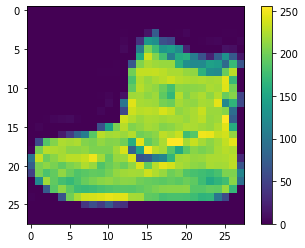

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. **It's important that the *training set* and the *testing set* be preprocessed in the same way:**

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

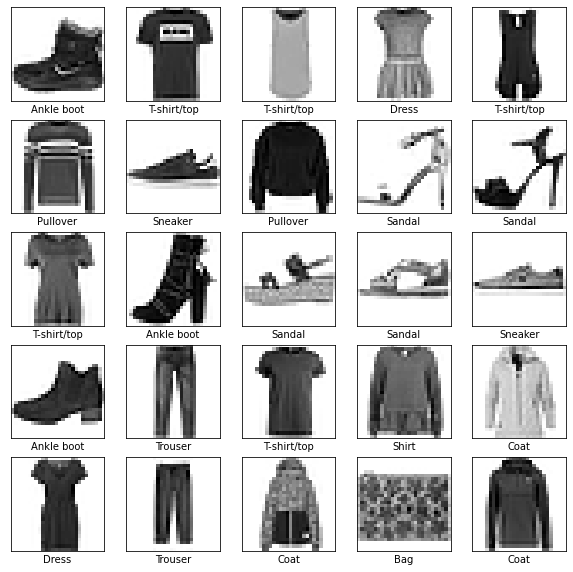

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5004 - accuracy: 0.8265
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3763 - accuracy: 0.8653
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3367 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3133 - accuracy: 0.8845
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2957 - accuracy: 0.8918
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2800 - accuracy: 0.8976
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2678 - accuracy: 0.9005
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2573 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2485 - accuracy: 0.9067
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.238

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3404 - accuracy: 0.8798 - 540ms/epoch - 2ms/step

Test accuracy: 0.879800021648407


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([1.4520732e-07, 4.4260396e-08, 3.1251324e-07, 2.8027999e-08,
       5.2324242e-07, 3.0271095e-04, 5.4475477e-05, 3.3889316e-02,
       1.0156372e-05, 9.6574235e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

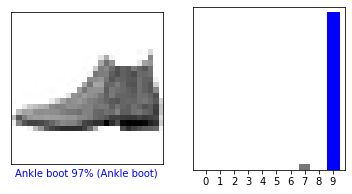

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

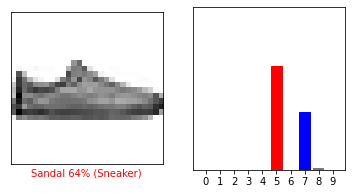

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

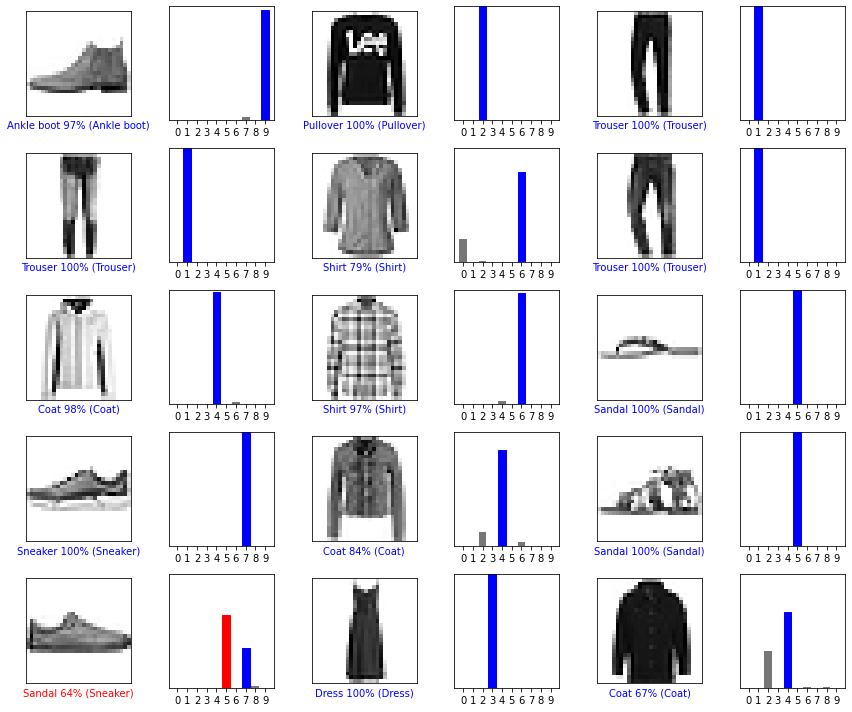

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[2.1220247e-05 1.6960106e-15 9.9918443e-01 1.3708393e-10 5.9697405e-04
  4.7373260e-13 1.9733651e-04 4.6776937e-15 6.8582209e-11 7.9261589e-14]]


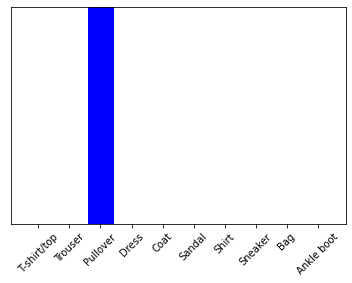

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.